# Import Library and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from autogluon.tabular import TabularDataset, TabularPredictor


/home/zwniff/anaconda3/envs/ag/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,NIK,Kepala_Keluarga,Alamat_Email,Usia,Tingkat_Pendidikan,Pekerjaan,Jumlah_Tanggungan,Lokasi,Pengalaman_Kerja,Status_Pernikahan,Status_Pekerjaan,Jumlah_Anggota_Rumah_Tangga,Status_Kepemilikan_Rumah,Jenis_Perkonomian,Jenis_Kelamin,Transportasi_Utama,Pendapatan
0,5287357533487145,Uli Langgeng Gandi,uli.langgeng31@icloud.com,NaN,SMA,Keuangan,3.0,Urban,31.0,Lajang,Part-time,NaN,Milik Sendiri,Rumah Tinggal,Laki-Laki,Bersepeda,75124.0
1,6614067227753442,Hana Langgeng Safitri,hana.langgeng43@icloud.com,40.0,SMA,Keuangan,5.0,Urban,19.0,Lajang,Full-time,2.0,Milik Sendiri,Rumah Susun,Perempuan,Bersepeda,72678.0
2,3393045411796906,Zani Taufik Laksana,zani.taufik91.@outlook.com,65.0,Sarjana,Kesehatan,2.0,Urban,13.0,Lajang,Full-time,2.0,Sewa,Rumah Tinggal,Perempuan,Bersepeda,224095.0
3,5615881970322210,Jali Gusti Eka Putra,jali.gusti@outlook.com,49.0,SMA,Kesehatan,5.0,Urban,3.0,Menikah,Full-time,7.0,Sewa,Apartemen,Laki-Laki,Transportasi Umum,34972.0
4,7351107714091610,Lia Ajeng Abdurrahman,lia.ajeng@icloud.com,56.0,Magister,Pendidikan,NaN,Urban,24.0,Menikah,Part-time,1.0,Milik Sendiri,Apartemen,Perempuan,Jalan Kaki,2191383.0


In [4]:
train.drop(['NIK', 'Kepala_Keluarga', 'Alamat_Email'], axis=1, inplace=True)

# EDA

In [6]:
train.describe()

,Usia,Jumlah_Tanggungan,Pengalaman_Kerja,Jumlah_Anggota_Rumah_Tangga,Pendapatan
count,7138.000000,7419.000000,7034.000000,6989.000000,7.266000e+03
mean,43.978565,2.523925,24.917117,3.985835,8.129830e+05
std,15.169371,1.709114,14.645460,2.013677,1.806345e+06
min,18.000000,0.000000,0.000000,1.000000,3.112700e+04
25%,31.000000,1.000000,12.000000,2.000000,6.859450e+04
50%,43.000000,3.000000,25.000000,4.000000,7.319800e+04
75%,57.000000,4.000000,37.000000,6.000000,3.744259e+05
max,74.000000,5.000000,54.000000,7.000000,1.161194e+07


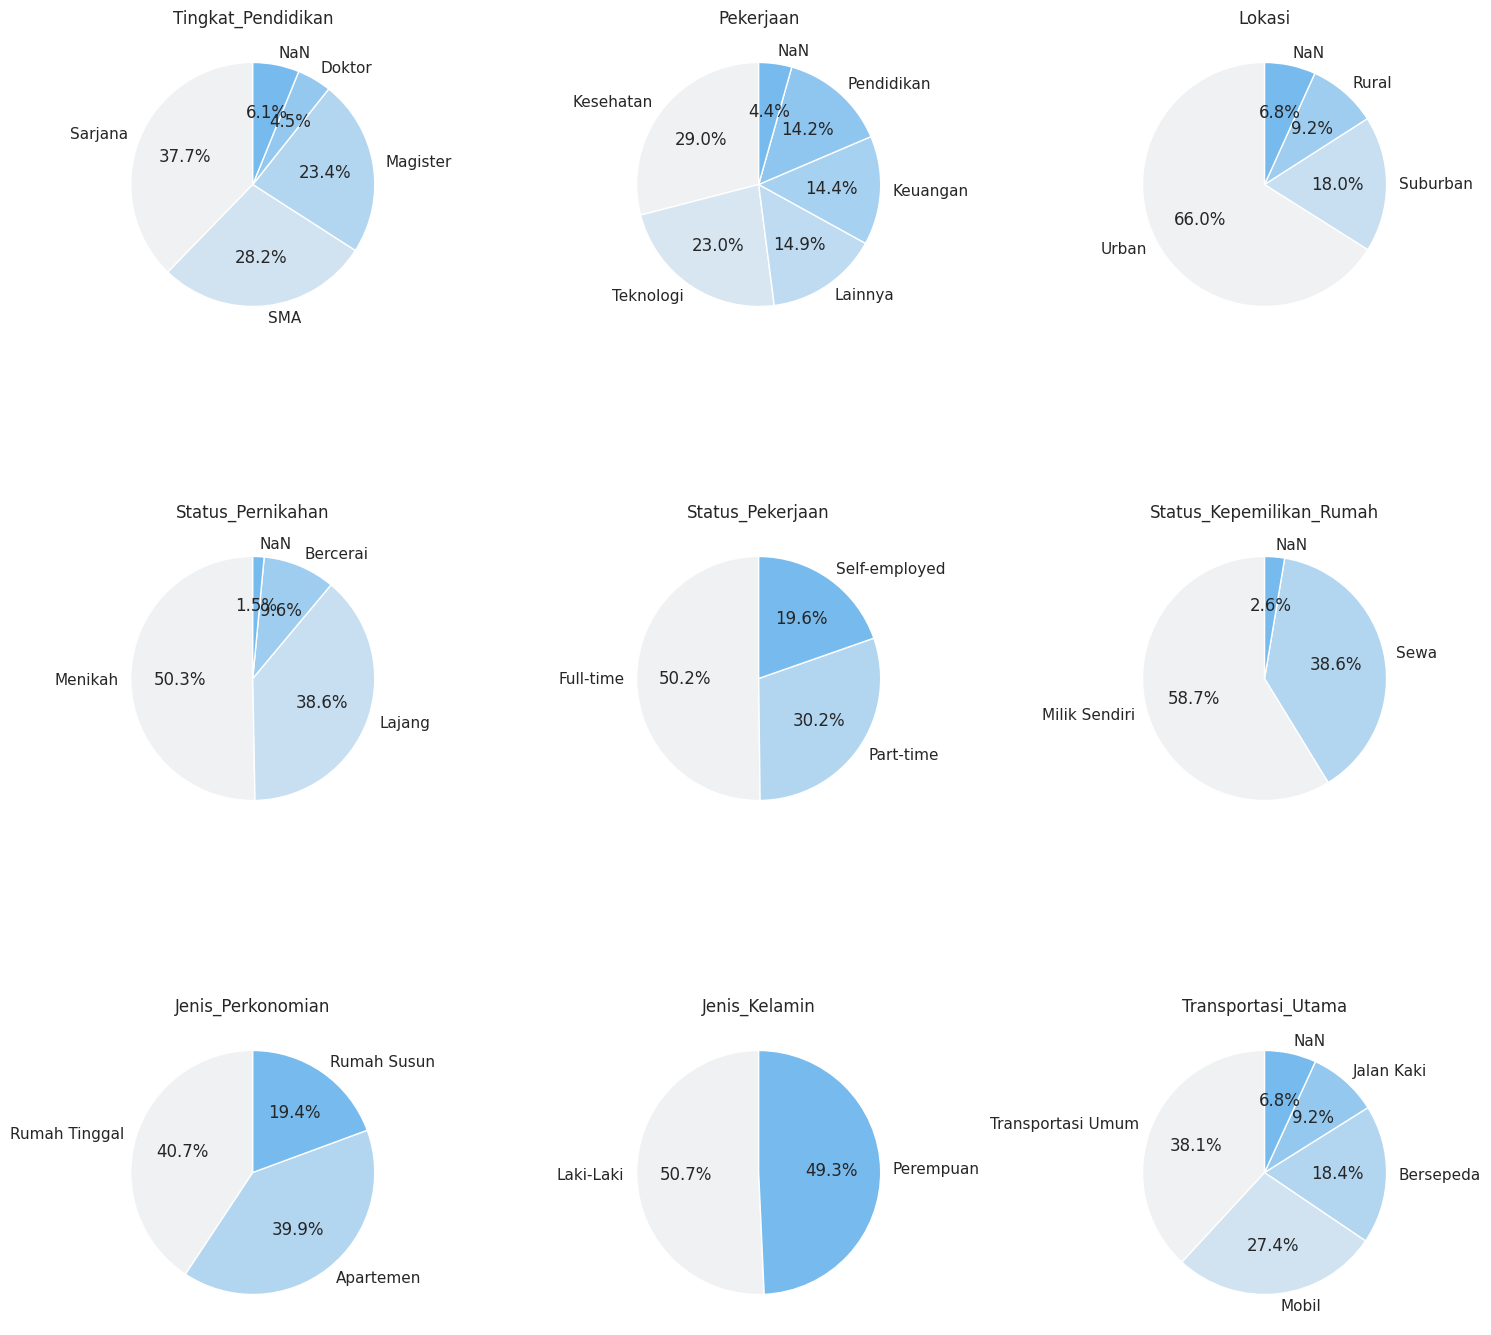

In [50]:
train_cat = train.select_dtypes(include=['object', 'category'])

# Set up the figure for pie charts
plt.figure(figsize=(15, 15))

# Set the Seaborn style
sns.set(style="whitegrid")

# Loop through each categorical column to create pie charts
for i, col in enumerate(train_cat.columns):
    plt.subplot(3, 3, i + 1)  # Adjust dimensions as needed
    
    # Count values, including NaNs
    counts = train_cat[col].value_counts()
    
    # Add NaN representation
    if train_cat[col].isnull().any():
        counts['NaN'] = train_cat[col].isnull().sum()
        
    # Plot pie chart
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("light:#7be", len(counts)))
    plt.title(col)

plt.tight_layout()
plt.show()

# Preprocessing

## HMV

In [7]:
missing = pd.DataFrame(train.isnull().sum(), columns=['train'])
missing['test'] = test.isnull().sum()

missing

,train,test
NIK,0,0.0
Kepala_Keluarga,0,0.0
Alamat_Email,0,0.0
Usia,362,0.0
Tingkat_Pendidikan,461,0.0
Pekerjaan,328,0.0
Jumlah_Tanggungan,81,0.0
Lokasi,507,0.0
Pengalaman_Kerja,466,0.0
Status_Pernikahan,112,0.0


### Remove row with missing value on pendapatan

In [8]:
train = train[train['Pendapatan'].notna()]

train['Pendapatan'].isna().sum()

0

### HMV cat

In [ ]:
from sklearn.impute import SimpleImputer

cat_imputer = SimpleImputer(strategy='most_frequent')
cat_column = train.select_dtypes(include='object').columns
train[cat_column] = cat_imputer.fit_transform(train[cat_column])

train.isnull().sum()

### HMV numerical

In [10]:
# from sklearn.impute import SimpleImputer

# num_imputer = SimpleImputer(strategy='median')
# num_column = train.select_dtypes(include='number').columns
# train[num_column] = num_imputer.fit_transform(train[num_column])

# train.isnull().sum()

# Encoding

In [11]:
cat_column = train.select_dtypes(include=['object', 'category']).columns
cat_column = list(cat_column)

train[cat_column] = train[cat_column].astype('category')
test[cat_column] = test[cat_column].astype('category')

In [12]:
train.drop(columns=['NIK', 'Kepala_Keluarga', 'Alamat_Email'], inplace=True)
test.drop(columns=['NIK', 'Kepala_Keluarga', 'Alamat_Email'], inplace=True)

# Modelling

In [13]:
train_ag = TabularDataset(train)
test_ag = TabularDataset(test)

# label = 'Pendapatan'

# predictor = TabularPredictor(label=label)

# predictor.fit(
#     train_data=train_ag,
#     time_limit=10800,
#     presets='best_quality',
#     num_gpus=1
#     )

In [14]:
predictor = TabularPredictor.load("AutogluonModels/ag-20241121_180214")

In [15]:
y_pred = predictor.predict(test_ag)

y_pred

0       1.878328e+05
1       3.668350e+05
2       1.064557e+05
3       9.549635e+04
4       6.533806e+05
            ...     
2495    1.821701e+05
2496    1.539131e+05
2497    1.537042e+05
2498    6.965702e+04
2499    1.285309e+06
Name: Pendapatan, Length: 2500, dtype: float32

In [16]:
submission = pd.read_csv('sample_submission.csv')
submission['Pendapatan'] = y_pred
submission.to_csv('submission.csv', index=False)

In [ ]:
l = predictor.leaderboard(silent=True)
l